<br>

<h1 style="text-align:center;">YOLO V8 using KerasCV</h1>

<br>

## Introduction

---

In this project, we will fine-tune YOLOv8 for efficient object detection using KerasCV.

In [ ]:
# Set the Keras backend to Jax
import os
os.environ["KERAS_BACKEND"] = "jax"

In [2]:
# Import the libraries
import numpy as np
import keras
import keras_cv
from keras_cv import bounding_box, visualization
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_cv

In [3]:
# Set matplotlib style
plt.style.use('ggplot')

<br>

## Hyperparameters

---


In [4]:
# Hyperparameters
BATCH_SIZE = 4
IMAGE_SIZE = (640, 640)
BOUNDING_BOX_FORMAT = "xywh"
BASE_LEARNING_RATE = 0.005

<br>

## Load Dataset

---


In [5]:
# Class mapping
class_ids = [
    "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus", "Car", "Cat", "Chair", "Cow", "Dining Table", "Dog",
    "Horse", "Motorbike", "Person", "Potted Plant", "Sheep", "Sofa", "Train", "Tvmonitor", "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

class_mapping

{0: 'Aeroplane',
 1: 'Bicycle',
 2: 'Bird',
 3: 'Boat',
 4: 'Bottle',
 5: 'Bus',
 6: 'Car',
 7: 'Cat',
 8: 'Chair',
 9: 'Cow',
 10: 'Dining Table',
 11: 'Dog',
 12: 'Horse',
 13: 'Motorbike',
 14: 'Person',
 15: 'Potted Plant',
 16: 'Sheep',
 17: 'Sofa',
 18: 'Train',
 19: 'Tvmonitor',
 20: 'Total'}

In [6]:
# Load VOC 2007 dataset
train_ds = tfds.load("voc/2007", split="train", with_info=False, shuffle_files=True)
val_ds = tfds.load("voc/2007", split="validation", with_info=False, shuffle_files=True)
test_ds = tfds.load("voc/2007", split="test", with_info=False, shuffle_files=True)

# Print the number of samples in each dataset
print(f"Number of samples in the training dataset: {len(train_ds)}")
print(f"Number of samples in the validation dataset: {len(val_ds)}")
print(f"Number of samples in the test dataset: {len(test_ds)}")

Number of samples in the training dataset: 2501
Number of samples in the validation dataset: 2510
Number of samples in the test dataset: 4952


In [7]:
# Function for preparing the data
def prepare_detection_data(inputs, bounding_box_format):

    # Get the image
    image = inputs["image"]

    # Boxes
    boxes = inputs["objects"]["bbox"]

    # Convert bounding boxes format from relative (ymin, xmin, ymax, xmax) to (x, y, w, h)
    boxes = keras_cv.bounding_box.convert_format(
        boxes,
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )

    # Output
    output = {
        "images": image,
        "bounding_boxes": {
            "classes": inputs["objects"]["label"],
            "boxes": boxes,
        }
    }

    return output

In [8]:
# Apply the function to the datasets
train_ds = train_ds.map(lambda x: prepare_detection_data(x, BOUNDING_BOX_FORMAT))
val_ds = val_ds.map(lambda x: prepare_detection_data(x, BOUNDING_BOX_FORMAT))
test_ds = test_ds.map(lambda x: prepare_detection_data(x, BOUNDING_BOX_FORMAT))

In [9]:
# Ragged batch the datasets (i.e., each batch may have a different number of samples)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

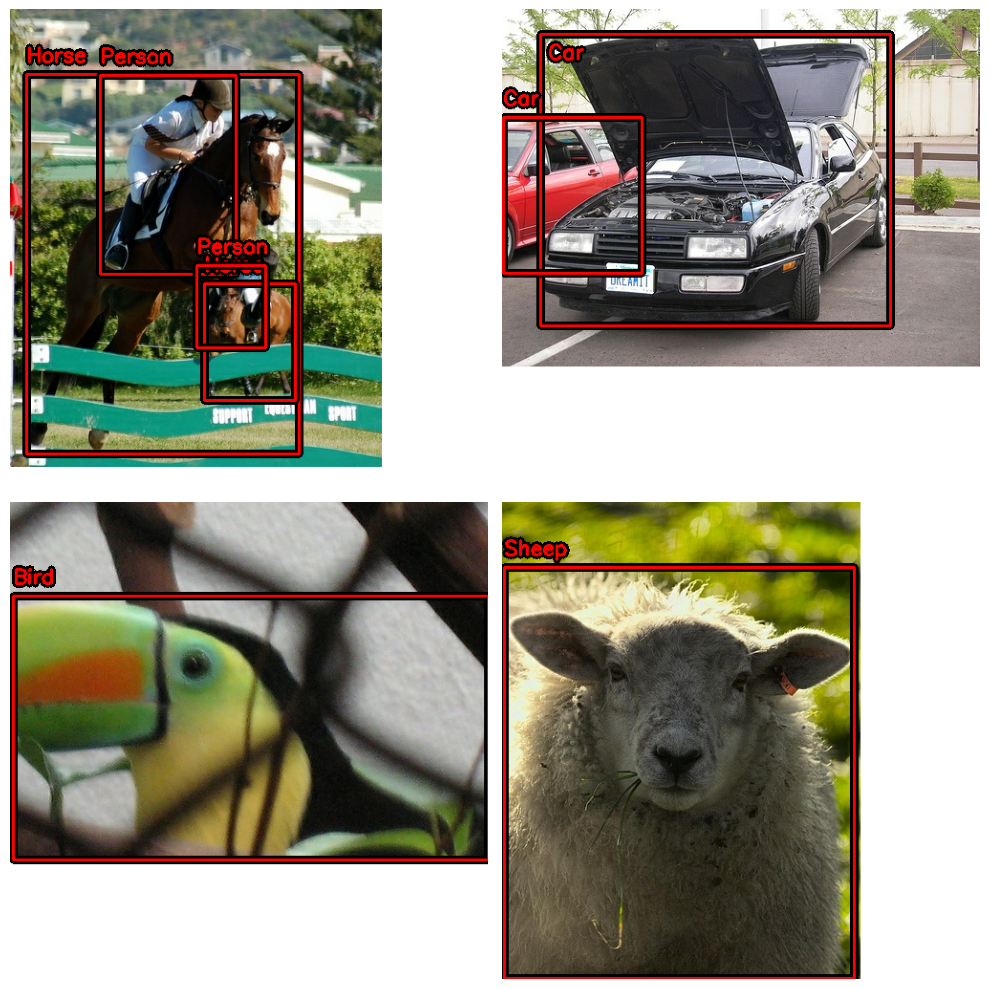

In [10]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):

    # Sample a batch
    inputs = next(iter(inputs.take(1)))

    # Plot the images
    visualization.plot_bounding_box_gallery(
        inputs["images"],
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=inputs["bounding_boxes"],
        #y_pred=preds["bounding_boxes"],
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color=(255, 0, 0),
        #pred_color=(0, 255, 0),
        line_thickness=2,
    )

# Visualize the training dataset
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

<br>

## Data Preprocessing

---


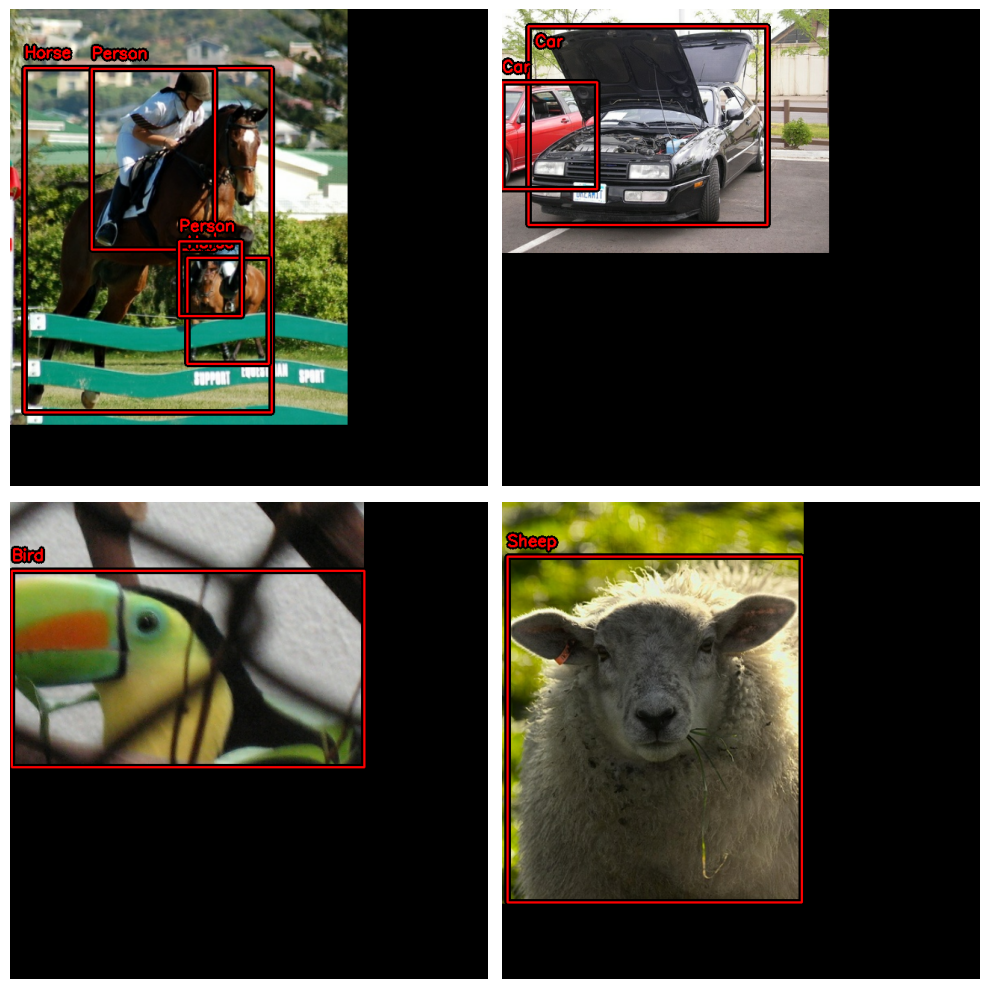

In [11]:
### Data augmentation for training set

# Augmentation pipeline
augmenters = [

    # Random flip
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),

    # Resize with scale distortion
    keras_cv.layers.JitteredResize(target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"),
]

# Function for applying augmenters
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs
    return augmenter_fn

# Initialize the augmenter function
augmenter_fn = create_augmenter_fn(augmenters)

# Apply the augmenters to the training dataset
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)

# Visualize the training dataset
visualize_dataset(train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2)

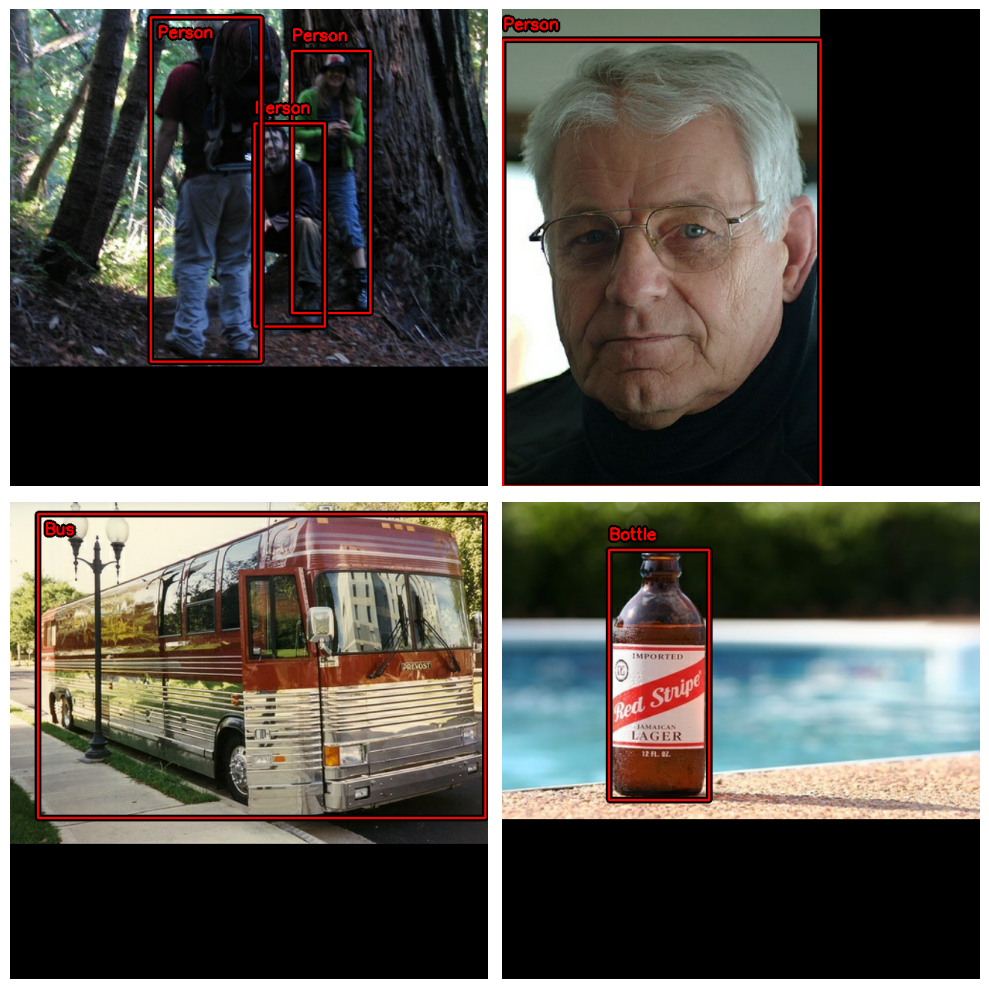

In [12]:
### Resize the validation and test datasets

# Resize layer
image_resizing_layer = keras_cv.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1], bounding_box_format="xywh", pad_to_aspect_ratio=True)

# Apply the resizing layer to the validation and test datasets
test_ds = test_ds.map(image_resizing_layer, num_parallel_calls=tf_data.AUTOTUNE)
val_ds = val_ds.map(image_resizing_layer, num_parallel_calls=tf_data.AUTOTUNE)

# Visualize the validation dataset
visualize_dataset(
    val_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [13]:

# Function to convert the dictionary to a tuple
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32)

# Apply the function to the datasets
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

In [14]:
# Prefetch the datasets
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

<br>

## Modeling

---


In [15]:
# Optimizer
optimizer = keras.optimizers.SGD(
    learning_rate=BASE_LEARNING_RATE, momentum=0.9, global_clipnorm=10.0  # global_clipnorm is very important for object detection tasks
)

In [17]:
# Instantiate model from preset config and weights
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    bounding_box_format="xywh",
    num_classes=len(class_mapping),
)

# Compile the model
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

# Callback for COCO metrics
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    #val_ds.take(20),
    val_ds,
    bounding_box_format="xywh"
)

# Train the model
model.fit(
    #train_ds.take(20),
    train_ds,
    epochs=3,
    callbacks=[coco_metrics_callback],
)

Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 342ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.53s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU

In [18]:
# Save the model
model.save("yolo_v8_fine_tuned.keras")

<br>

# Prediction

---

In [30]:
# Load the model
model = keras.models.load_model("yolo_v8_fine_tuned.keras")

# Compile the model
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [40]:
# Prediction decoder for applying non-maximum suppression (this is used during inference)
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

# Update the model's prediction decoder
model.prediction_decoder = prediction_decoder


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


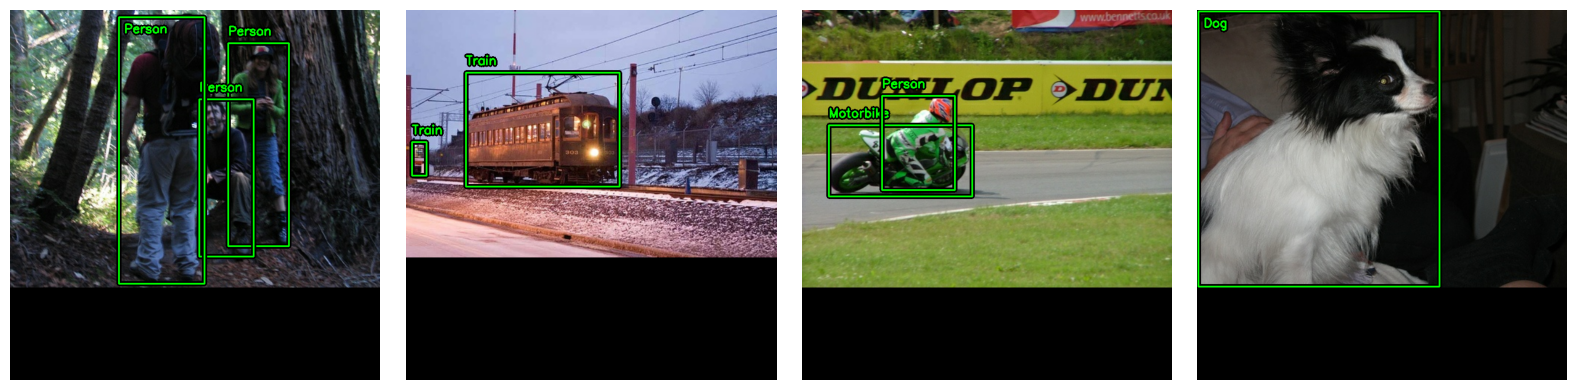

In [41]:
# Function for visualizing detections
def visualize_detections(model, dataset, bounding_box_format):

    # Sample a batch
    images, y_true = next(iter(dataset.take(1)))

    # Predict
    y_pred = model.predict(images)

    # Plot the images
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color=(0, 255, 0),
        pred_color=(0, 0, 255),
        scale=4,
        rows=1,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

# Visualize detections on the validation dataset
visualize_detections(model, dataset=val_ds, bounding_box_format="xywh")